# Part 2: Sentiment Analysis- Movie Reviews

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

## Reading the dataset

In [ ]:
imdb_data=pd.read_csv("IMDB Dataset.csv")
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Visualizing Sentiments:

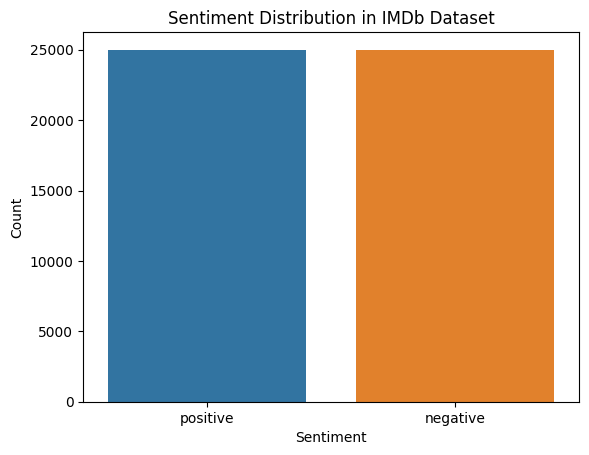

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of positive and negative sentiments
sentiment_counts = imdb_data['sentiment'].value_counts()

# Create a bar chart
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution in IMDb Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


We have a balanced dataset!

### Data Pre-processing

In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Train-Test Split

In [ ]:
#split the dataset
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Text Pre-processing

Tokenizing Texts

In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

C:\Users\19452\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Removing Special Characters

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

### Stemming text

In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

### Removing Stopwords

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'ain', 'ours', "isn't", 'because', 'ma', 'any', "hadn't", "should've", 'doing', 'can', 'after', 'their', 'most', 'don', 'no', 'me', 'theirs', 'why', 'do', 'once', 'above', 'themselves', 'from', 't', "you'll", 'just', 'mustn', 'yours', 'yourself', 'them', 'than', 'an', 'to', 'd', 'is', 'him', 'other', 'here', 'both', 'if', 'nor', 'herself', 'himself', 'before', 'mightn', 'such', 'should', "doesn't", "needn't", 'weren', "it's", 'been', 'wouldn', 'it', 'did', 'few', "shouldn't", 'further', 'against', 'hasn', 'his', 'over', 'y', "won't", 'how', 'needn', 'shouldn', 'off', 'same', "haven't", 'wasn', 'that', 'not', 'your', 'he', 'between', 's', 'yourselves', 'and', "wasn't", "don't", 'my', 'they', 'o', 'only', "she's", "hasn't", 'very', 'won', 'again', 'in', 'being', 'a', 're', 'so', 'isn', 'below', 'out', 'shan', 'has', 'own', 'myself', "wouldn't", 'until', 'then', 'under', 'there', 'the', 'didn', 'our', 'at', 'was', 'during', 'aren', "you're", "didn't", 'itself', 'or', 'haven', 'through', 

### Normalizing training dataset

In [ ]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

### Normalizing test dataset

In [ ]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

### Applying Bag of Words with Count Vectorization

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


### TFIDF Vectorization

In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [ ]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# Building Models

## 1. Logistic Regression

In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Model Evaluation LR

In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


In [ ]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Confusion Matrix

In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


## 2. SVM

In [ ]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


### Evaluating SVM model

In [ ]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


In [ ]:
#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



### 3. Multinomial Naive Bayes for bag of words and tfidf features



In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


C:\Users\19452\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Evaluating the model

In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


In [ ]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## Building Deep Learning Model: CNN model

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten,Conv1D, GlobalMaxPooling1D, Dense, LSTM
from tensorflow.keras.activations import relu, sigmoid

### Preprocessing text

In [ ]:

lm = WordNetLemmatizer()
def text_processing(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

# data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project work/IMDB movies review sentiment analysis/IMDB Dataset.csv")
df=imdb_data.copy()
# df['review'] = text_processing(df['review'])

In [ ]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

Tokenization and padding

In [ ]:
# Tokenization and padding
max_words = 1000  # Maximum number of words in your vocabulary
max_seq_length = 100  # Maximum length of sequences (words in a review)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['review'])

X_train = tokenizer.texts_to_sequences(train_df['review'])
X_test = tokenizer.texts_to_sequences(test_df['review'])

X_train = pad_sequences(X_train, maxlen=max_seq_length, padding = 'post')
X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post')

y_train = np.array(train_df['sentiment'])
y_test = np.array(test_df['sentiment'])

### Build the CNN model

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length))
model.add(Conv1D(filters=128, kernel_size=5, activation=relu))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation=relu))
model.add(Dense(1, activation=sigmoid))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          100000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 172449 (673.63 KB)
Trainable params: 172449 (673.63 KB)
Non-trainable params: 0 (0.00 Byte)
______________

### Train the model

In [ ]:
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 25s 39ms/step - loss: 0.4610 - accuracy: 0.7727 - val_loss: 0.3605 - val_accuracy: 0.8370
Epoch 2/10
625/625 [==============================] - 23s 37ms/step - loss: 0.2917 - accuracy: 0.8761 - val_loss: 0.3589 - val_accuracy: 0.8410
Epoch 3/10
625/625 [==============================] - 25s 41ms/step - loss: 0.1946 - accuracy: 0.9257 - val_loss: 0.3655 - val_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0933 - accuracy: 0.9704 - val_loss: 0.4566 - val_accuracy: 0.8370
Epoch 5/10
625/625 [==============================] - 25s 41ms/step - loss: 0.0323 - accuracy: 0.9929 - val_loss: 0.5264 - val_accuracy: 0.8500
Epoch 6/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.6040 - val_accuracy: 0.8476
Epoch 7/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.6512 - val_accuracy:

### Evaluate the model on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.7610 - accuracy: 0.8515
Test Loss: 0.7610474228858948
Test Accuracy: 0.8514800071716309


### Visualizing loss and training accuracy

Test Loss: 0.7610474228858948
Test Accuracy: 0.8514800071716309


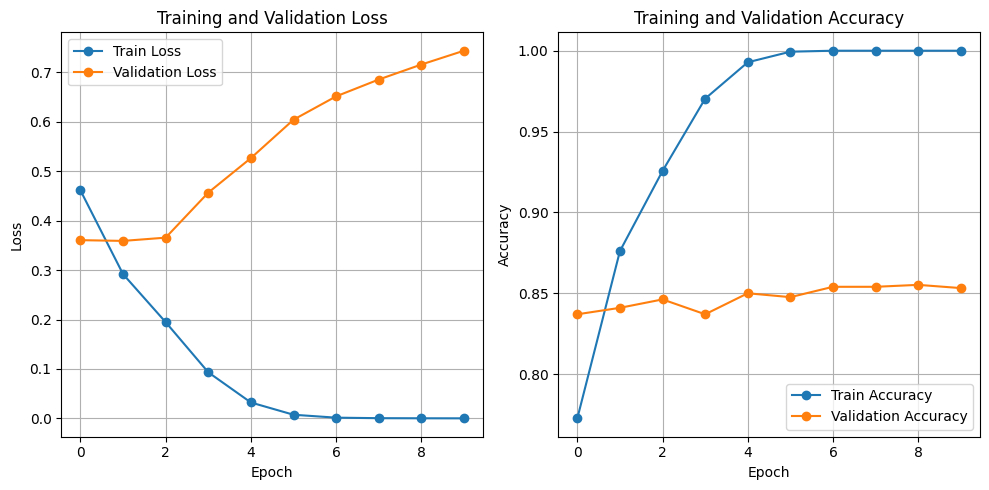

782/782 [==============================] - 8s 11ms/step


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

test_predictions_probs = model.predict(X_test)
test_predictions = (test_predictions_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
#score_model(test_predictions)

### CNN Model Conclusion:

We achieved the following results:

- **Test Loss:** 0.7610
- **Test Accuracy:** 85.15%

**Model Architecture:**

- The CNN model consists of several key layers:
  - **Embedding Layer:** This layer is responsible for converting input text data into dense vector representations. It uses an embedding matrix with 100,000 words and maps text sequences to 100-dimensional vectors.
  - **Conv1D Layer:** The convolutional layer with 128 filters extracts important features from the text data. It uses a filter size of 4, reducing the sequence length from 100 to 96.
  - **Global Max Pooling1D Layer:** This layer identifies the most important feature in each feature map and reduces the dimensionality to 128.
  - **Dense Layers:** The model includes two dense layers with 64 and 1 units, respectively. The final dense layer provides binary classification output (0 or 1).

**Model Performance:**

- The model's performance is commendable with an accuracy of 85.15%. This high accuracy indicates that the model is effective in classifying text data into the specified categories.

- The test loss of 0.7610 suggests that the model is capable of making precise predictions with relatively low error.

**Model Parameters:**

- The model has a total of 172,449 parameters, including both trainable and non-trainable parameters. The embedding layer is the largest contributor to the total number of parameters.

**Conclusion:**

The CNN model presented a strong performance in text classification, achieving an accuracy of 85.15%. It successfully leveraged convolutional layers to extract relevant features from text data, making it suitable for sentiment analysis

To further improve the model, potential enhancements could include hyperparameter tuning, data augmentation, and exploration of more complex network architectures. <br>
Additionally, the model's efficiency and generalization capabilities can be further assessed by evaluating its performance on larger and more diverse text datasets.

### Summary of Models:<br>

Multinomial Naive Bayes and Logistic Regression demonstrated balanced performance with an accuracy of 75%. They provided consistent results for both positive and negative sentiments.
The SVM model, while offering high precision for negative sentiment, faced challenges with positive sentiment classification, leading to an accuracy of 58%.
The CNN model outperformed the other models with an accuracy of **85.15%.**